# Understanding Neural Networks: From Pixels to Predictions

*A visual guide to how neural networks learn, using edge detection as our example*

---

Neural networks can seem intimidating. Terms like "cross-entropy loss," "softmax," and "backpropagation" sound complex. But at their core, these are just clever combinations of simple operations.

This tutorial explains **how neural networks learn** — specifically, how they automatically discover the right weights through training. We'll use **edge detection** as our running example: training a network to look at a small image patch and answer "Is there a vertical edge here?"

By the end, you'll understand:
- How a neuron detects patterns (like edges)
- How we measure "wrongness" with the loss function  
- How backpropagation computes gradients
- How gradient descent learns the right weights

**Companion post:** For a deeper dive into how a single neuron works as a pattern detector (weights, ReLU, bias), see [How Neural Networks Learn to See: Building an Edge Detector from Scratch](https://snowch.github.io/nn_edge_detector_blog.html). This tutorial focuses on the *training* process — how the network discovers those weights automatically.


In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False


---

## Part 1: The Problem - Detecting Edges

Let's start with a concrete task. Given a 5x5 grayscale image patch, we want to classify it:
- **Class 0: "Edge"** - there's a vertical edge (dark-to-bright transition)
- **Class 1: "No Edge"** - uniform or other pattern

Here are some examples:


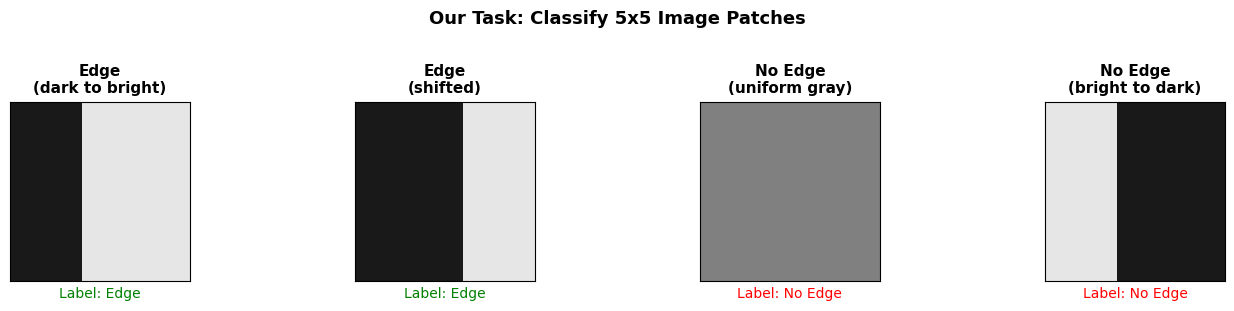

In [2]:
# Show example image patches
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

examples = [
    ("Edge\n(dark to bright)", [[0.1, 0.1, 0.9, 0.9, 0.9]]*5, "Edge"),
    ("Edge\n(shifted)", [[0.1, 0.1, 0.1, 0.9, 0.9]]*5, "Edge"),
    ("No Edge\n(uniform gray)", [[0.5, 0.5, 0.5, 0.5, 0.5]]*5, "No Edge"),
    ("No Edge\n(bright to dark)", [[0.9, 0.9, 0.1, 0.1, 0.1]]*5, "No Edge"),
]

for ax, (title, pixels, label) in zip(axes, examples):
    img = np.array(pixels)
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel(f'Label: {label}', fontsize=10, 
                  color='green' if label == "Edge" else 'red')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Our Task: Classify 5x5 Image Patches', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### The Network's Job

Our neural network will:
1. Take 25 pixel values as input (the 5×5 patch flattened into a **vector**)
2. Process them through weights and activations
3. Output two scores: one for "Edge", one for "No Edge"
4. Convert scores to probabilities using **softmax**
5. Compare to the true label using the **loss function**

<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 15px; margin: 15px 0;">

**📐 Important: Notation Guide**

- **Lowercase** ($x$, $z$, $w$) → Scalar (single number), e.g. $x = 0.5$
- **Lowercase bold** ($\mathbf{x}$, $\mathbf{z}$) → Vector (array), e.g. $\mathbf{x} = [0.1, 0.5, 0.9]$
- **Subscript** ($x_i$, $w_i$) → Element $i$ of a vector, e.g. $x_0 = 0.1$
- **Uppercase** ($W$, $X$) → Matrix (grid), e.g. $W$ is 25×8

</div>

Let's build up each piece.


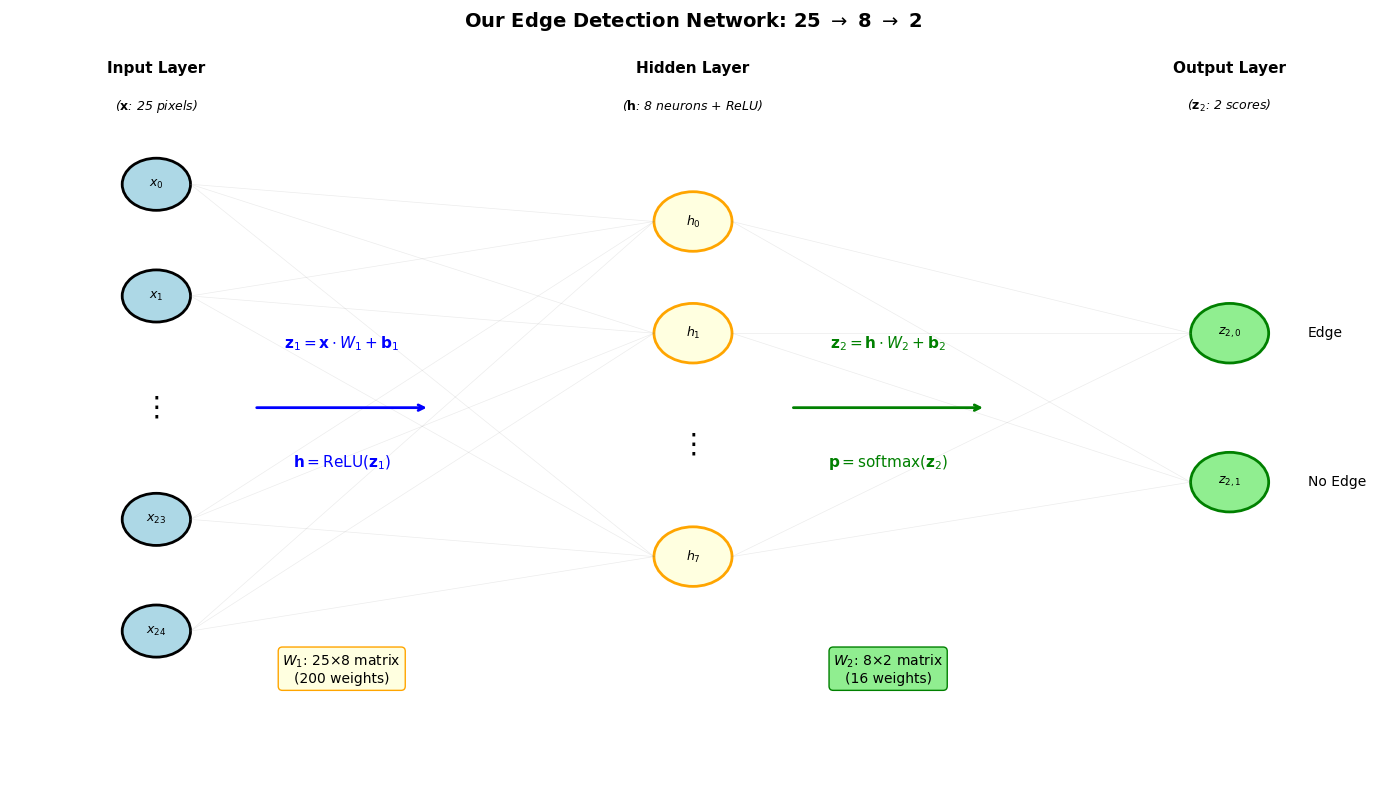

In [3]:
# Network architecture diagram with nodes and connections
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False  # Use mathtext instead (more compatible)

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title(r'Our Edge Detection Network: 25 $\rightarrow$ 8 $\rightarrow$ 2', fontsize=14, fontweight='bold')

# Define layer positions
input_x = 1.5
hidden_x = 7
output_x = 12.5

# Input layer - show subset of 25 nodes
input_ys = [8, 6.5, 5, 3.5, 2]
input_labels = [r'$x_0$', r'$x_1$', '...', r'$x_{23}$', r'$x_{24}$']

ax.text(input_x, 9.5, 'Input Layer', fontsize=11, fontweight='bold', ha='center')
ax.text(input_x, 9.0, r'($\mathbf{x}$: 25 pixels)', fontsize=9, ha='center', style='italic')

for y, label in zip(input_ys, input_labels):
    if label == '...':
        ax.text(input_x, y, chr(8942), fontsize=20, ha='center', va='center')  # vertical ellipsis
    else:
        circle = plt.Circle((input_x, y), 0.35, color='lightblue', ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(input_x, y, label, fontsize=9, ha='center', va='center')

# Hidden layer - show subset of 8 nodes (elements of h vector)
hidden_ys = [7.5, 6, 4.5, 3]
hidden_labels = [r'$h_0$', r'$h_1$', '...', r'$h_7$']

ax.text(hidden_x, 9.5, 'Hidden Layer', fontsize=11, fontweight='bold', ha='center')
ax.text(hidden_x, 9.0, r'($\mathbf{h}$: 8 neurons + ReLU)', fontsize=9, ha='center', style='italic')

for y, label in zip(hidden_ys, hidden_labels):
    if label == '...':
        ax.text(hidden_x, y, chr(8942), fontsize=20, ha='center', va='center')
    else:
        circle = plt.Circle((hidden_x, y), 0.4, color='lightyellow', ec='orange', linewidth=2)
        ax.add_patch(circle)
        ax.text(hidden_x, y, label, fontsize=9, ha='center', va='center')

# Output layer - 2 nodes (elements of z2 vector)
output_ys = [6, 4]
output_labels = [r'$z_{2,0}$', r'$z_{2,1}$']
output_names = ['Edge', 'No Edge']

ax.text(output_x, 9.5, 'Output Layer', fontsize=11, fontweight='bold', ha='center')
ax.text(output_x, 9.0, r'($\mathbf{z}_2$: 2 scores)', fontsize=9, ha='center', style='italic')

for y, label, name in zip(output_ys, output_labels, output_names):
    circle = plt.Circle((output_x, y), 0.4, color='lightgreen', ec='green', linewidth=2)
    ax.add_patch(circle)
    ax.text(output_x, y, label, fontsize=9, ha='center', va='center')
    ax.text(output_x + 0.8, y, name, fontsize=10, ha='left', va='center')

# Draw connections (simplified - just show some)
for in_y in [8, 6.5, 3.5, 2]:
    for h_y in [7.5, 6, 3]:
        ax.plot([input_x + 0.35, hidden_x - 0.4], [in_y, h_y], 'gray', alpha=0.15, linewidth=0.5)

for h_y in [7.5, 6, 3]:
    for out_y in [6, 4]:
        ax.plot([hidden_x + 0.4, output_x - 0.4], [h_y, out_y], 'gray', alpha=0.15, linewidth=0.5)

# Formula annotations - using LaTeX mathtext for bold vectors
ax.annotate('', xy=(4.3, 5), xytext=(2.5, 5), arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.text(3.4, 5.8, r'$\mathbf{z}_1 = \mathbf{x} \cdot W_1 + \mathbf{b}_1$', fontsize=11, ha='center', color='blue')
ax.text(3.4, 4.2, r'$\mathbf{h} = \mathrm{ReLU}(\mathbf{z}_1)$', fontsize=11, ha='center', color='blue')

ax.annotate('', xy=(10, 5), xytext=(8, 5), arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax.text(9, 5.8, r'$\mathbf{z}_2 = \mathbf{h} \cdot W_2 + \mathbf{b}_2$', fontsize=11, ha='center', color='green')
ax.text(9, 4.2, r'$\mathbf{p} = \mathrm{softmax}(\mathbf{z}_2)$', fontsize=11, ha='center', color='green')

# Weight matrix labels
ax.text(3.4, 1.3, r'$W_1$: 25×8 matrix' + '\n(200 weights)', fontsize=10, ha='center', 
        bbox=dict(boxstyle='round', facecolor='lightyellow', ec='orange'))
ax.text(9, 1.3, r'$W_2$: 8×2 matrix' + '\n(16 weights)', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', ec='green'))

plt.tight_layout()
plt.show()


### Seeing the Forward Pass in Action

Let's trace real numbers through the network. We'll create a 5×5 edge image and watch the values flow:

In [4]:
# Create a sample edge image (dark left, bright right)
image = np.array([
    [0.1, 0.1, 0.5, 0.9, 0.9],
    [0.1, 0.1, 0.5, 0.9, 0.9],
    [0.1, 0.1, 0.5, 0.9, 0.9],
    [0.1, 0.1, 0.5, 0.9, 0.9],
    [0.1, 0.1, 0.5, 0.9, 0.9],
])
print("Input image (5×5):")
print(image)
print(f"\nThis is an EDGE: dark on left, bright on right")

# Flatten to vector x
x = image.flatten().reshape(1, -1)  # Shape: (1, 25)
print(f"\nFlattened to vector x: shape {x.shape}")
print(f"x = [{x[0,0]:.1f}, {x[0,1]:.1f}, ... {x[0,-1]:.1f}]")

# Initialize small random weights for demo
np.random.seed(123)
W1 = np.random.randn(25, 8) * 0.3
b1 = np.zeros((1, 8))
W2 = np.random.randn(8, 2) * 0.3
b2 = np.zeros((1, 2))

# Layer 1: Input → Hidden
z1 = x @ W1 + b1        # Shape: (1, 8)
h = np.maximum(0, z1)   # ReLU activation

print(f"\n--- Layer 1 ---")
print(f"z1 = x @ W1 + b1,  shape: {z1.shape}")
print(f"z1 = [{z1[0,0]:+.2f}, {z1[0,1]:+.2f}, {z1[0,2]:+.2f}, ...]")
print(f"\nh = ReLU(z1)  -- negative values become 0")
print(f"h  = [{h[0,0]:.2f}, {h[0,1]:.2f}, {h[0,2]:.2f}, ...]")

# Layer 2: Hidden → Output
z2 = h @ W2 + b2        # Shape: (1, 2)

print(f"\n--- Layer 2 ---")
print(f"z2 = h @ W2 + b2,  shape: {z2.shape}")
print(f"z2 = [{z2[0,0]:+.2f}, {z2[0,1]:+.2f}]  (Edge, No-Edge)")

# Softmax
exp_z2 = np.exp(z2 - np.max(z2))
p = exp_z2 / np.sum(exp_z2)

print(f"\n--- Softmax ---")
print(f"p = softmax(z2)")
print(f"p = [{p[0,0]:.3f}, {p[0,1]:.3f}]")

prediction = "Edge" if p[0,0] > p[0,1] else "No Edge"
confidence = p.max() * 100
print(f"\n→ Prediction: {prediction} ({confidence:.1f}% confident)")
print(f"  (Random weights - prediction may be wrong!)")

Input image (5×5):
[[0.1 0.1 0.5 0.9 0.9]
 [0.1 0.1 0.5 0.9 0.9]
 [0.1 0.1 0.5 0.9 0.9]
 [0.1 0.1 0.5 0.9 0.9]
 [0.1 0.1 0.5 0.9 0.9]]

This is an EDGE: dark on left, bright on right

Flattened to vector x: shape (1, 25)
x = [0.1, 0.1, ... 0.9]

--- Layer 1 ---
z1 = x @ W1 + b1,  shape: (1, 8)
z1 = [-0.27, -1.06, +0.58, ...]

h = ReLU(z1)  -- negative values become 0
h  = [0.00, 0.00, 0.58, ...]

--- Layer 2 ---
z2 = h @ W2 + b2,  shape: (1, 2)
z2 = [-0.07, -0.41]  (Edge, No-Edge)

--- Softmax ---
p = softmax(z2)
p = [0.583, 0.417]

→ Prediction: Edge (58.3% confident)
  (Random weights - prediction may be wrong!)


---

## Part 2: How a Neuron Detects Patterns

A neuron performs a simple two-step calculation:

### Step 1: Weighted Sum

$$z = \sum_{i} x_i \cdot w_i + b$$

Each input $x_i$ (a scalar — one pixel value) is multiplied by its weight $w_i$ (also a scalar), all products are summed, and a bias $b$ (scalar) is added. The result $z$ is a single number.

- **Weights** determine how much each input matters
- **Bias** shifts when the neuron "fires"

With vectors: if $\mathbf{x}$ is the input vector (25 pixels) and $\mathbf{w}$ is the weight vector (25 weights), then $z = \mathbf{x} \cdot \mathbf{w} + b$ (dot product).

### Step 2: Activation (ReLU)

$$h = \text{ReLU}(z) = \max(0, z)$$

**ReLU** (Rectified Linear Unit) is the simplest activation:
- If z > 0: output z (pass through)
- If z ≤ 0: output 0 (block it)

The activation function adds **non-linearity**. Without it, stacking layers would be pointless — the whole network would just be one big linear equation!

> **Why non-linearity matters:**
>
> *The problem with pure linear layers:* A linear function always does the same thing to every input: multiply and add. If you chain two linear functions, you still just get multiply and add — $z_2 = (x W_1) W_2 = x (W_1 W_2)$. It collapses to a single operation. You can only draw straight lines.
>
> *How ReLU fixes this:* ReLU makes a **decision** based on the input:
>
> `if z > 0: pass it through`
>
> `if z ≤ 0: block it (output 0)`
> 
> This "if/else" behavior is the key! A purely linear function has no "if" — it blindly does the same multiplication regardless of input. ReLU says "it depends on the value." Different inputs get treated differently.
>
> With many neurons, each making its own if/else decision, the network can carve up the input space into regions, handling each region differently. That's how it learns complex, non-linear patterns.

**Implementation:**

```python
z = np.dot(x, w) + b    # x and w are vectors (length 25), z is a scalar
h = np.maximum(0, z)    # h is a scalar
```


### The Key Insight

**The weights define what pattern the neuron responds to.**

The output $h$ is essentially a **score** for how well the input matches the weight pattern. High score = good match. Zero = no match (or negative match blocked by ReLU).

The chart below shows ReLU in action:
- **Left:** The ReLU function itself — notice how negative values become 0
- **Right:** Four example neurons with different weighted sums (z values). Neurons A and C had positive z, so their outputs pass through. Neurons B and D had negative z, so ReLU blocks them (output = 0).


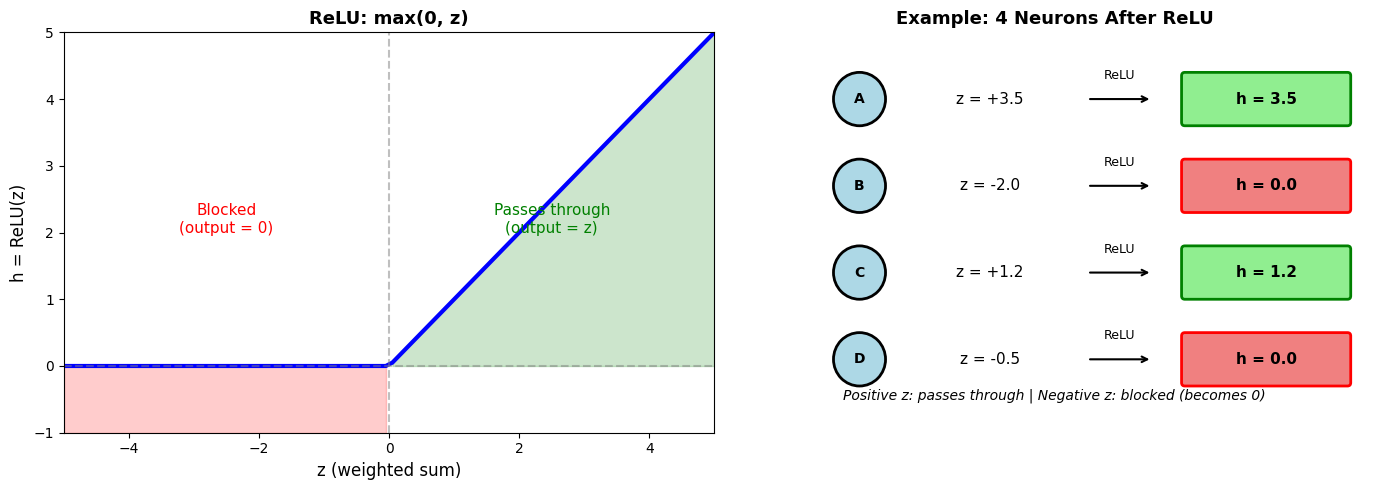

In [5]:
# Visualize ReLU activation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: ReLU function
ax1 = axes[0]
z = np.linspace(-5, 5, 100)
h = np.maximum(0, z)
ax1.plot(z, h, 'b-', linewidth=3)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('h = ReLU(z)', fontsize=12)
ax1.set_title('ReLU: max(0, z)', fontsize=13, fontweight='bold')
ax1.set_xlim(-5, 5)
ax1.set_ylim(-1, 5)

# Annotate regions
ax1.fill_between(z[z<0], 0, -1, alpha=0.2, color='red')
ax1.fill_between(z[z>0], 0, h[z>0], alpha=0.2, color='green')
ax1.text(-2.5, 2, 'Blocked\n(output = 0)', fontsize=11, ha='center', color='red')
ax1.text(2.5, 2, 'Passes through\n(output = z)', fontsize=11, ha='center', color='green')

# Right panel: Example with feature detectors
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 6)
ax2.axis('off')
ax2.set_title('Example: 4 Neurons After ReLU', fontsize=13, fontweight='bold')

# Show 4 example neurons with their z values and outputs
examples = [
    ('Neuron A', 3.5, 3.5, 'green'),   # positive -> passes
    ('Neuron B', -2.0, 0.0, 'red'),    # negative -> blocked
    ('Neuron C', 1.2, 1.2, 'green'),   # positive -> passes
    ('Neuron D', -0.5, 0.0, 'red'),    # negative -> blocked
]

for idx, (name, z_val, h_val, color) in enumerate(examples):
    y_pos = 5 - idx * 1.3
    
    # Neuron circle
    circle = plt.Circle((2, y_pos), 0.4, color='lightblue', ec='black', linewidth=2)
    ax2.add_patch(circle)
    ax2.text(2, y_pos, name[-1], ha='center', va='center', fontsize=10, fontweight='bold')
    
    # z value
    ax2.text(4, y_pos, f'z = {z_val:+.1f}', fontsize=11, ha='center', va='center')
    
    # Arrow
    ax2.annotate('', xy=(6.5, y_pos), xytext=(5.5, y_pos),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    ax2.text(6, y_pos + 0.3, 'ReLU', fontsize=9, ha='center')
    
    # Output
    bg_color = 'lightgreen' if color == 'green' else 'lightcoral'
    ax2.add_patch(mpatches.FancyBboxPatch((7, y_pos - 0.35), 2.5, 0.7, 
                  boxstyle='round,pad=0.05', facecolor=bg_color, edgecolor=color, linewidth=2))
    ax2.text(8.25, y_pos, f'h = {h_val:.1f}', ha='center', va='center', fontsize=11, fontweight='bold')

ax2.text(5, 0.5, 'Positive z: passes through | Negative z: blocked (becomes 0)', 
         fontsize=10, ha='center', style='italic')

plt.tight_layout()
plt.show()


### Now Let's See Pattern Detection in Action

Below we show how the weights create a "template" that the neuron matches against:


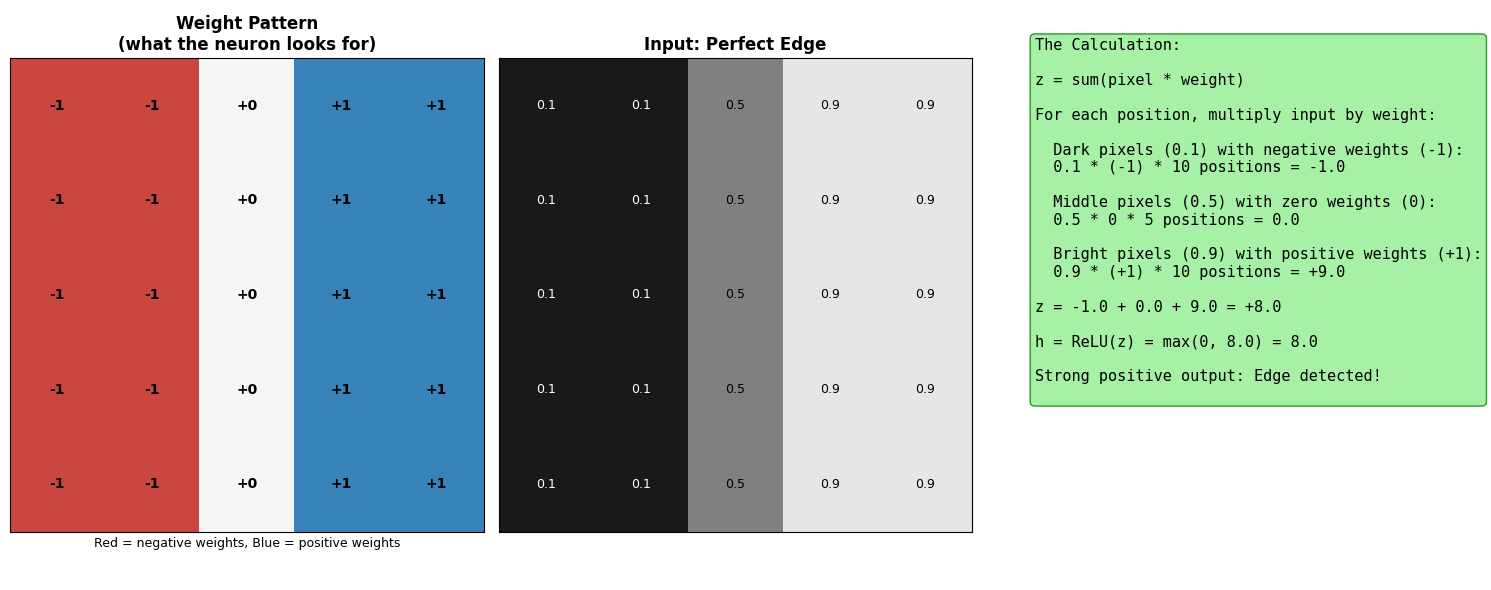

In [6]:
# Show neuron as edge detector
fig = plt.figure(figsize=(16, 6))

# Panel 1: The weight pattern
ax1 = fig.add_subplot(1, 3, 1)
weights_2d = np.array([[-1, -1, 0, 1, 1]]*5)
im = ax1.imshow(weights_2d, cmap='RdBu', vmin=-1.5, vmax=1.5)
ax1.set_title('Weight Pattern\n(what the neuron looks for)', fontsize=12, fontweight='bold')
for i in range(5):
    for j in range(5):
        ax1.text(j, i, f'{weights_2d[i,j]:+d}', ha='center', va='center', fontsize=10, fontweight='bold')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('Red = negative weights, Blue = positive weights', fontsize=9)

# Panel 2: Perfect edge input
ax2 = fig.add_subplot(1, 3, 2)
edge_input = np.array([[0.1, 0.1, 0.5, 0.9, 0.9]]*5)
ax2.imshow(edge_input, cmap='gray', vmin=0, vmax=1)
ax2.set_title('Input: Perfect Edge', fontsize=12, fontweight='bold')
for i in range(5):
    for j in range(5):
        ax2.text(j, i, f'{edge_input[i,j]:.1f}', ha='center', va='center', fontsize=9, 
                color='white' if edge_input[i,j] < 0.5 else 'black')
ax2.set_xticks([])
ax2.set_yticks([])

# Panel 3: Calculation
ax3 = fig.add_subplot(1, 3, 3)
ax3.axis('off')

# Calculate the weighted sum
weights_flat = weights_2d.flatten()
input_flat = edge_input.flatten()
weighted_sum = np.sum(weights_flat * input_flat)
relu_output = max(0, weighted_sum)

calc_text = '''The Calculation:

z = sum(pixel * weight)

For each position, multiply input by weight:

  Dark pixels (0.1) with negative weights (-1):
  0.1 * (-1) * 10 positions = -1.0
  
  Middle pixels (0.5) with zero weights (0):
  0.5 * 0 * 5 positions = 0.0
  
  Bright pixels (0.9) with positive weights (+1):
  0.9 * (+1) * 10 positions = +9.0

z = -1.0 + 0.0 + 9.0 = +8.0

h = ReLU(z) = max(0, 8.0) = 8.0

Strong positive output: Edge detected!
'''
ax3.text(0.1, 0.95, calc_text, fontsize=11, family='monospace',
         verticalalignment='top', transform=ax3.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightgreen', ec='green', alpha=0.8))

plt.tight_layout()
plt.show()


### Why This Works

The weights encode a **template**:
- **Negative weights** on the left say "I want dark pixels here"
- **Positive weights** on the right say "I want bright pixels here"

When the input **matches** the template:
- Dark * negative = positive contribution
- Bright * positive = positive contribution
- Sum is large and positive: **strong output**

When the input **doesn't match**:
- Bright * negative = negative contribution
- These cancel out or go negative
- ReLU blocks negative values: **zero output**


### Testing on Different Inputs

How does our edge detector respond to different patterns? The chart below tests 5 inputs:

- **Perfect Edge**: Dark left, bright right — exactly what our weights want → High score!
- **Shifted Right/Left**: Edge is there but not aligned with weights → Reduced score
- **Uniform Gray**: No contrast at all → Zero (positive and negative weights cancel out)
- **Inverted Edge**: Bright left, dark right — opposite of what we want → Negative, blocked by ReLU


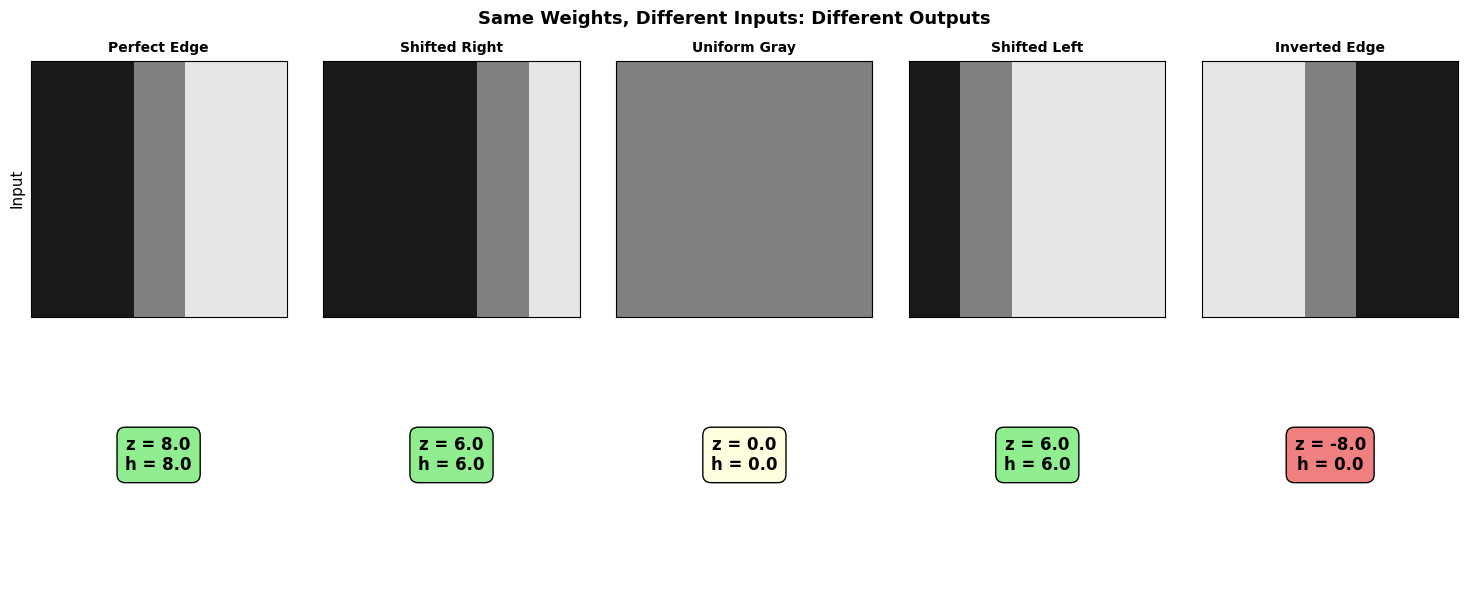

Key insight: The neuron responds most strongly when input matches the weight pattern!


In [7]:
# Show different inputs to same neuron
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

weights = np.array([-1, -1, 0, 1, 1])  # per column

test_cases = [
    ("Perfect Edge", [0.1, 0.1, 0.5, 0.9, 0.9]),
    ("Shifted Right", [0.1, 0.1, 0.1, 0.5, 0.9]),
    ("Uniform Gray", [0.5, 0.5, 0.5, 0.5, 0.5]),
    ("Shifted Left", [0.1, 0.5, 0.9, 0.9, 0.9]),
    ("Inverted Edge", [0.9, 0.9, 0.5, 0.1, 0.1]),
]

for idx, (name, pixels) in enumerate(test_cases):
    # Top row: show the input
    ax_top = axes[0, idx]
    img = np.array([pixels]*5)
    ax_top.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax_top.set_title(name, fontsize=10, fontweight='bold')
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    
    # Calculate output
    z = sum(p * w for p, w in zip(pixels, weights)) * 5  # 5 rows
    h = max(0, z)
    
    # Bottom row: show the calculation
    ax_bot = axes[1, idx]
    ax_bot.axis('off')
    
    color = 'lightgreen' if h > 0 else 'lightyellow' if z == 0 else 'lightcoral'
    result = f"z = {z:.1f}\nh = {h:.1f}"
    ax_bot.text(0.5, 0.5, result, ha='center', va='center', fontsize=12, fontweight='bold',
               transform=ax_bot.transAxes,
               bbox=dict(boxstyle='round,pad=0.5', facecolor=color, ec='black'))

axes[0, 0].set_ylabel('Input', fontsize=11)
axes[1, 0].set_ylabel('Output', fontsize=11)
plt.suptitle('Same Weights, Different Inputs: Different Outputs', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key insight: The neuron responds most strongly when input matches the weight pattern!")


---

## Part 3: From Scores to Probabilities - Softmax

We saw that neurons produce **scores** — higher means better pattern match. But for classification, we need **probabilities**: "What's the chance this is an edge?"

Our network has two output neurons (one for "Edge", one for "No Edge"), each producing a score. So we have a **vector of scores** $\mathbf{z} = [z_{edge}, z_{no\_edge}]$. These raw scores (also called **logits**) can be any number — positive, negative, or zero.

**Softmax** converts this score vector into a **probability vector** where:
1. All values are positive
2. They sum to 1.0

### The Formula

For a vector of scores $\mathbf{z}$ with $n$ elements:

$$P_j = \frac{e^{z_j}}{\sum_{k=1}^{n} e^{z_k}}$$

Each probability $P_j$ is a scalar. The output is a vector $\mathbf{p} = [P_1, P_2, ..., P_n]$.

### Step by Step

The visualization below shows the 3-step process:
1. **Raw scores** (vector) — can be any numbers
2. **Exponentials** (vector) — $e^{z_j}$ makes each element positive
3. **Normalize** (vector) — divide each by the sum, so they sum to 1.0


**Implementation:** (end of forward pass)

```python
exp_scores = np.exp(scores - np.max(scores))  # exponentiate (stable)
probabilities = exp_scores / np.sum(exp_scores)  # normalize
```

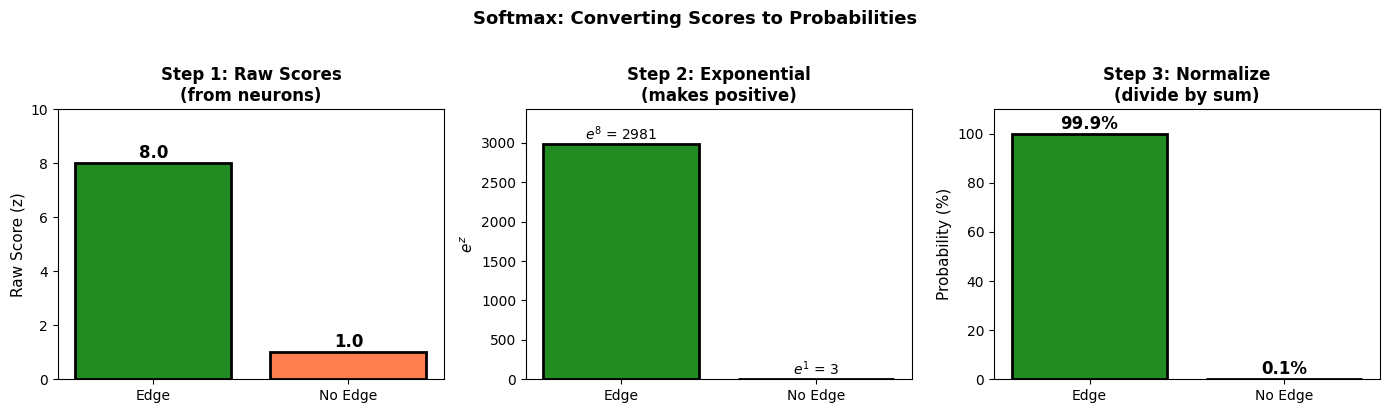

Result: P(Edge) = 99.9%, P(No Edge) = 0.1%
The network is 99.9% confident this is an edge.


In [8]:
# Show softmax with edge detection example
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Example scores for an edge image
scores = [8.0, 1.0]  # [Edge score, No Edge score]
labels = ['Edge', 'No Edge']
colors = ['forestgreen', 'coral']

# Step 1: Raw scores
ax1 = axes[0]
bars1 = ax1.bar(labels, scores, color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('Raw Score (z)', fontsize=11)
ax1.set_title('Step 1: Raw Scores\n(from neurons)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 10)
for bar, s in zip(bars1, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{s:.1f}', 
             ha='center', fontsize=12, fontweight='bold')

# Step 2: Exponentials
exp_scores = [np.exp(s) for s in scores]
ax2 = axes[1]
ax2.set_ylim(0, max(exp_scores) * 1.15)
bars2 = ax2.bar(labels, exp_scores, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('$e^z$', fontsize=11)
ax2.set_title('Step 2: Exponential\n(makes positive)', fontsize=12, fontweight='bold')
for bar, e, s in zip(bars2, exp_scores, scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'$e^{{{s:.0f}}}$ = {e:.0f}', 
             ha='center', fontsize=10)

# Step 3: Normalize
total = sum(exp_scores)
probs = [e/total * 100 for e in exp_scores]
ax3 = axes[2]
bars3 = ax3.bar(labels, probs, color=colors, edgecolor='black', linewidth=2)
ax3.set_ylabel('Probability (%)', fontsize=11)
ax3.set_title('Step 3: Normalize\n(divide by sum)', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 110)
for bar, p in zip(bars3, probs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{p:.1f}%', 
             ha='center', fontsize=12, fontweight='bold')

plt.suptitle(f'Softmax: Converting Scores to Probabilities', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Result: P(Edge) = {probs[0]:.1f}%, P(No Edge) = {probs[1]:.1f}%")
print(f"The network is {probs[0]:.1f}% confident this is an edge.")


---

## Part 4: Measuring Wrongness - The Loss Function

Now we can measure how wrong the network is. We need a single number (scalar) that tells us "how bad was this prediction?"

### The Setup

The network outputs a probability vector $\mathbf{p} = [P_{edge}, P_{no\_edge}]$.

| | P(Edge) | P(No Edge) | True Label | $p_{correct}$ |
|---|---------|------------|------------|-----------|
| **Good prediction** | 0.95 | 0.05 | Edge | 0.95 |
| **Uncertain** | 0.5 | 0.5 | Edge | 0.5 |
| **Wrong prediction** | 0.1 | 0.9 | Edge | 0.1 |

$p_{correct}$ is a scalar — whichever probability corresponds to the true class.

### The Formula: Cross-Entropy Loss

$$L = -\log(p_{correct})$$

This is called **cross-entropy loss** (also known as log loss). The loss $L$ is a scalar.

> **Why "cross-entropy"?** 
> 
> The full formula is: $L = -\sum_i y_i \log(p_i)$
>
> This measures the "cross-entropy" between two probability distributions: what the network predicts ($\mathbf{p}$) vs. the truth ($\mathbf{y}$). When they match perfectly, cross-entropy is minimized. The name comes from information theory — it measures how many "bits" of surprise you get when the true distribution is $\mathbf{y}$ but you expected $\mathbf{p}$.
>
> Since $\mathbf{y}$ is one-hot (all zeros except one 1), the sum simplifies to just $-\log(p_{correct})$.

### Why This Works

The chart below shows the loss curve. Notice how:
- High $p_{correct}$ (near 1.0) → Low loss ✓
- Low $p_{correct}$ (near 0.0) → Very high loss ✗

The **logarithm** is key — it severely punishes cases where the network assigned low probability to the correct answer!


**Implementation:** (after forward pass)

```python
loss = -np.sum(y_true * np.log(p_predicted + 1e-8))
```

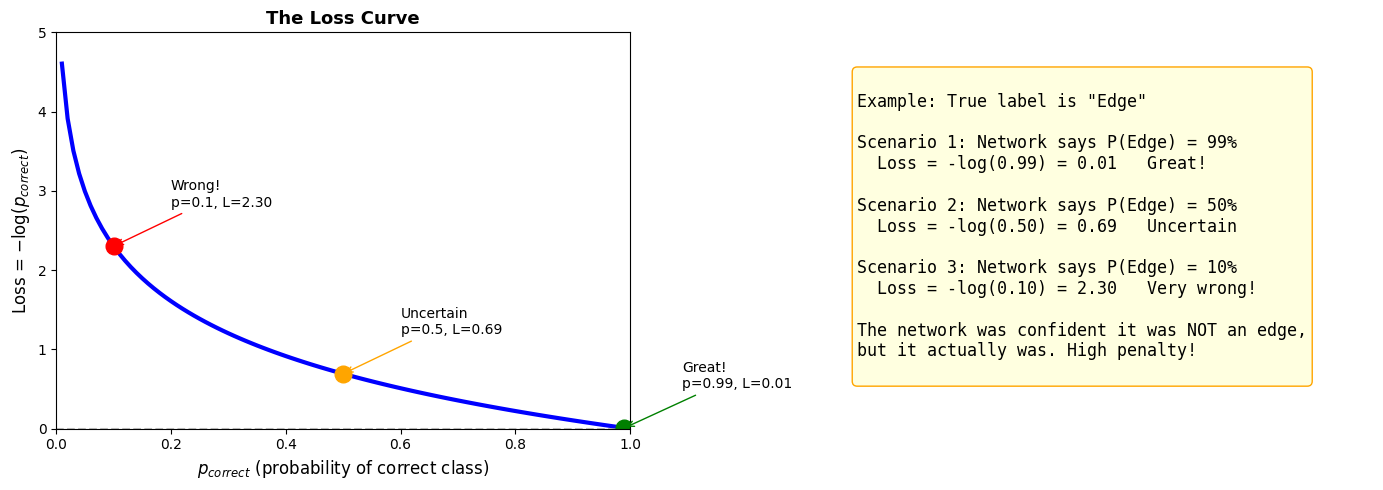

In [9]:
# Show loss function
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: The loss curve
ax1 = axes[0]
p = np.linspace(0.01, 1.0, 100)
loss = -np.log(p)
ax1.plot(p, loss, 'b-', linewidth=3)
ax1.set_xlabel('$p_{correct}$ (probability of correct class)', fontsize=12)
ax1.set_ylabel(r"Loss = $-\log(p_{correct})$", fontsize=12)
ax1.set_title('The Loss Curve', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 5)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Mark some points
points = [(0.99, 'Great!', 'green'), (0.5, 'Uncertain', 'orange'), (0.1, 'Wrong!', 'red')]
for p_val, label, color in points:
    l_val = -np.log(p_val)
    ax1.plot(p_val, l_val, 'o', markersize=12, color=color)
    ax1.annotate(f'{label}\np={p_val}, L={l_val:.2f}', xy=(p_val, l_val), 
                xytext=(p_val + 0.1, l_val + 0.5), fontsize=10,
                arrowprops=dict(arrowstyle='->', color=color))

# Right: Example scenarios
ax2 = axes[1]
ax2.axis('off')

scenarios = '''
Example: True label is "Edge"

Scenario 1: Network says P(Edge) = 99%
  Loss = -log(0.99) = 0.01   Great!
  
Scenario 2: Network says P(Edge) = 50%
  Loss = -log(0.50) = 0.69   Uncertain
  
Scenario 3: Network says P(Edge) = 10%
  Loss = -log(0.10) = 2.30   Very wrong!
  
The network was confident it was NOT an edge,
but it actually was. High penalty!
'''
ax2.text(0.1, 0.9, scenarios, fontsize=12, family='monospace',
         verticalalignment='top', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightyellow', ec='orange'))

plt.tight_layout()
plt.show()


### Why Logarithm?

The log has a special property: it **severely punishes confident wrong answers**.

- If p_correct = 0.99: Loss = 0.01 (tiny)
- If p_correct = 0.50: Loss = 0.69 (moderate)  
- If p_correct = 0.10: Loss = 2.30 (large)
- If p_correct = 0.01: Loss = 4.60 (huge!)

This makes sense: a network that says "I'm 99% sure it's NOT an edge" when it IS an edge should be penalized heavily.


### The Summation Trick

You might see the loss formula written as:

$$L = -\sum_{l} y_l \cdot \log(p_l)$$

This sums over all classes. Here $\mathbf{y}$ and $\mathbf{p}$ are vectors, and we're summing element-wise products.

But since $\mathbf{y}$ is **one-hot encoded** (1 for the correct class, 0 for all others), only one term survives!

For example, if "Edge" is correct: $\mathbf{y} = [1, 0]$, $\mathbf{p} = [p_{edge}, p_{no\_edge}]$

$$L = -(1 \cdot \log(p_{edge}) + 0 \cdot \log(p_{no\_edge})) = -\log(p_{edge})$$

The $\mathbf{y}$ vector acts as a **selector** — picking out only the correct class's probability. This is why the loss simplifies to $L = -\log(p_{correct})$ (a scalar).


---

## Interlude: The Chain Rule

Before we learn how networks update their weights, we need one key idea from calculus: **the chain rule**.

### The Problem

We want to know: how does the loss (a scalar) change when we tweak one weight (also a scalar)? But the weight doesn't directly affect the loss — it goes through several steps:

$$w \xrightarrow{\times x} z \xrightarrow{\text{softmax}} p \xrightarrow{-\log} L$$

How do we compute $\frac{\partial L}{\partial w}$ when $w$ affects $L$ indirectly?

### The Chain Rule

If $y = f(g(x))$ — that is, $y$ depends on $g$, and $g$ depends on $x$ — then:

$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial g} \cdot \frac{\partial g}{\partial x}$$

**Multiply the derivatives along the path.** All these are scalars.

> **Intuition:** If $g$ doubles when $x$ increases by 1, and $y$ triples when $g$ increases by 1, then $y$ increases by $2 \times 3 = 6$ when $x$ increases by 1.

### A Concrete Example

In neural networks, a single weight contributes to the score: $z = w \cdot x$ (scalars here).

This means $\frac{\partial z}{\partial w} = x$ — **the gradient of a weight equals its input!**

Let's verify with $L = z^2$ (simplified loss), $w = 3$, and $x = 2$:
- $z = 3 \times 2 = 6$
- $L = 6^2 = 36$

Applying the chain rule:
$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial w} = 2z \cdot x = 12 \times 2 = 24$$

**Verification:** If $w$ goes from $3$ to $3.01$:
- New $z = 3.01 \times 2 = 6.02$
- New $L = 6.02^2 = 36.24$
- Change in $L$ ≈ $0.24 = 24 \times 0.01$ ✓

This pattern — **weight gradient = input × gradient from above** — is the core of backpropagation.


---

## Part 5: Learning - How Do We Find the Right Weights?

So far we've assumed the weights are "correct" (negative on left, positive on right). But how does the network **learn** these weights from scratch?

The answer is **gradient descent**:
1. Start with random weights
2. Measure the loss (how wrong are we?)
3. Compute the **gradient** (which direction makes loss smaller?)
4. Update weights in that direction
5. Repeat!

### The Gradient

The gradient tells us: **if I increase this weight slightly, does the loss go up or down?**

$$\frac{\partial L}{\partial w} = \text{"how much does loss change when I change } w \text{?"}$$

- If gradient is **positive**: increasing w increases loss, so **decrease w**
- If gradient is **negative**: increasing w decreases loss, so **increase w**

> **Worked Example:** Let's trace through one weight update.
>
> Input pixel $x = 0.8$, weight $w = 0.5$.
>
> **Forward pass:**
> - Score: $z = x \cdot w = 0.8 \times 0.5 = 0.4$
> - After softmax: $p = 0.6$ for this class
> - True label: $y = 1$ (this is the correct class)
> - Loss: $L = -\log(0.6) = 0.51$
>
> **Backward pass (chain rule):**
>
> $$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial w}$$
>
> - $\frac{\partial L}{\partial z} = p - y = 0.6 - 1 = -0.4$ (from softmax + cross-entropy)
> - $\frac{\partial z}{\partial w} = x = 0.8$ (always the input, since $z = xw$)
> - $\frac{\partial L}{\partial w} = -0.4 \times 0.8 = -0.32$
>
> **Update:** With learning rate $\alpha = 0.1$:
> $$w_{new} = 0.5 - 0.1 \times (-0.32) = 0.532$$
>
> The gradient was negative (increasing $w$ decreases loss), so we increased $w$!

### The Update Rule

$$w_{\text{new}} = w_{\text{old}} - \alpha \cdot \frac{\partial L}{\partial w}$$

We move **opposite** to the gradient (downhill), scaled by the learning rate $\alpha$.

### Terminology

- **Iteration**: One weight update (forward pass → compute loss → backward pass → update)
- **Epoch**: One complete pass through all training examples
- **Batch**: A subset of training data used for one iteration (for efficiency)


**Implementation:** (end of each iteration)

```python
W = W - learning_rate * dL_dW  # update weights
b = b - learning_rate * dL_db  # update bias
```

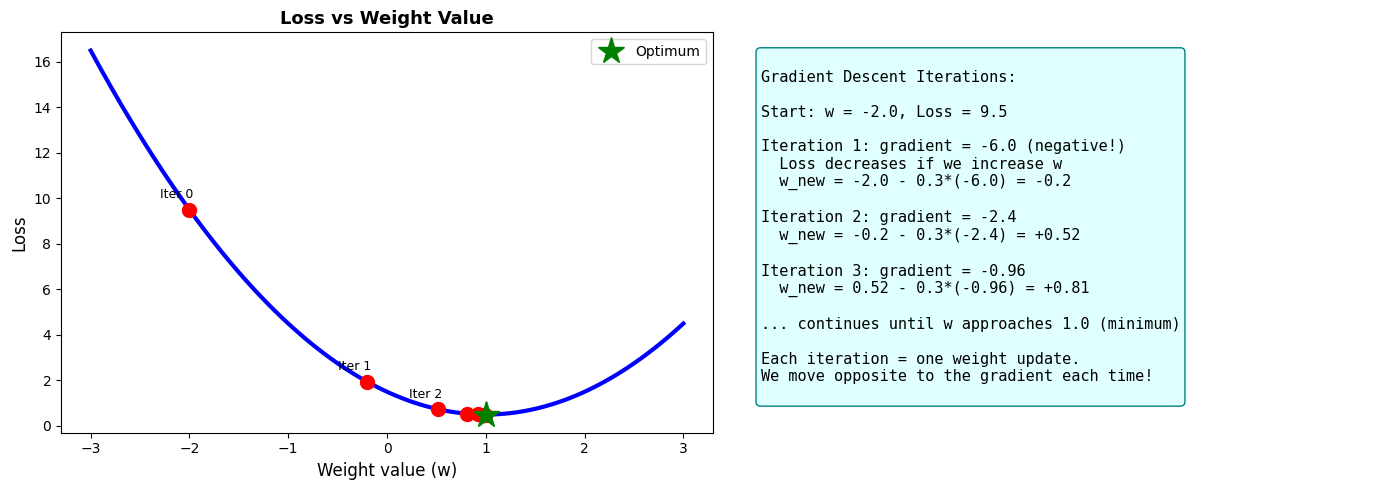

Terminology:
  - Iteration: one weight update (compute gradient, update weights)
  - Epoch: one full pass through all training data
  - Batch: a subset of training data used per iteration


In [10]:
# Visualize gradient descent on a simple 1D example
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Loss landscape
ax1 = axes[0]
w = np.linspace(-3, 3, 100)
# Simple quadratic loss for illustration
loss = (w - 1)**2 + 0.5
ax1.plot(w, loss, 'b-', linewidth=3)
ax1.set_xlabel('Weight value (w)', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss vs Weight Value', fontsize=13, fontweight='bold')

# Show gradient descent steps
w_start = -2.0
learning_rate = 0.3
w_history = [w_start]
for i in range(8):
    w_current = w_history[-1]
    gradient = 2 * (w_current - 1)  # derivative of (w-1)^2
    w_new = w_current - learning_rate * gradient
    w_history.append(w_new)

for i, w_val in enumerate(w_history[:-1]):
    loss_val = (w_val - 1)**2 + 0.5
    ax1.plot(w_val, loss_val, 'ro', markersize=10)
    if i < 3:
        ax1.annotate(f'Iter {i}', xy=(w_val, loss_val), xytext=(w_val-0.3, loss_val+0.5), fontsize=9)

ax1.plot(1, 0.5, 'g*', markersize=20, label='Optimum')
ax1.legend()

# Right: The update process
ax2 = axes[1]
ax2.axis('off')

update_text = """
Gradient Descent Iterations:

Start: w = -2.0, Loss = 9.5

Iteration 1: gradient = -6.0 (negative!)
  Loss decreases if we increase w
  w_new = -2.0 - 0.3*(-6.0) = -0.2

Iteration 2: gradient = -2.4
  w_new = -0.2 - 0.3*(-2.4) = +0.52
  
Iteration 3: gradient = -0.96
  w_new = 0.52 - 0.3*(-0.96) = +0.81
  
... continues until w approaches 1.0 (minimum)

Each iteration = one weight update.
We move opposite to the gradient each time!
"""
ax2.text(0.05, 0.95, update_text, fontsize=11, family='monospace',
         verticalalignment='top', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightcyan', ec='teal'))

plt.tight_layout()
plt.show()

print("Terminology:")
print("  - Iteration: one weight update (compute gradient, update weights)")
print("  - Epoch: one full pass through all training data")
print("  - Batch: a subset of training data used per iteration")


---

## Part 6: Backpropagation - Computing Gradients Efficiently

In Part 5, we saw the update rule requires $\frac{\partial L}{\partial w}$ for each weight. But our network has **many weights** — how do we compute all these gradients efficiently?

### From Scalars to Matrices

So far we've talked about single weights. In practice:
- **Input**: $\mathbf{x}$ is a vector (25 pixels)
- **Weights**: $W$ is a matrix (25×8 for our hidden layer)
- **Output**: $\mathbf{z}$ is a vector (8 hidden activations)

The forward pass becomes: $\mathbf{z} = \mathbf{x} W + \mathbf{b}$ (matrix multiplication)

### Backpropagation

**Backpropagation** applies the chain rule efficiently using matrix operations. We compute gradients layer by layer, starting from the loss and working backwards.

For a layer with input $\mathbf{x}$ (vector), weights $W$ (matrix), and output $\mathbf{z}$ (vector):

$$\frac{\partial L}{\partial W} = \mathbf{x}^T \cdot \frac{\partial L}{\partial \mathbf{z}}$$

The gradient for the entire weight matrix is computed in one operation!


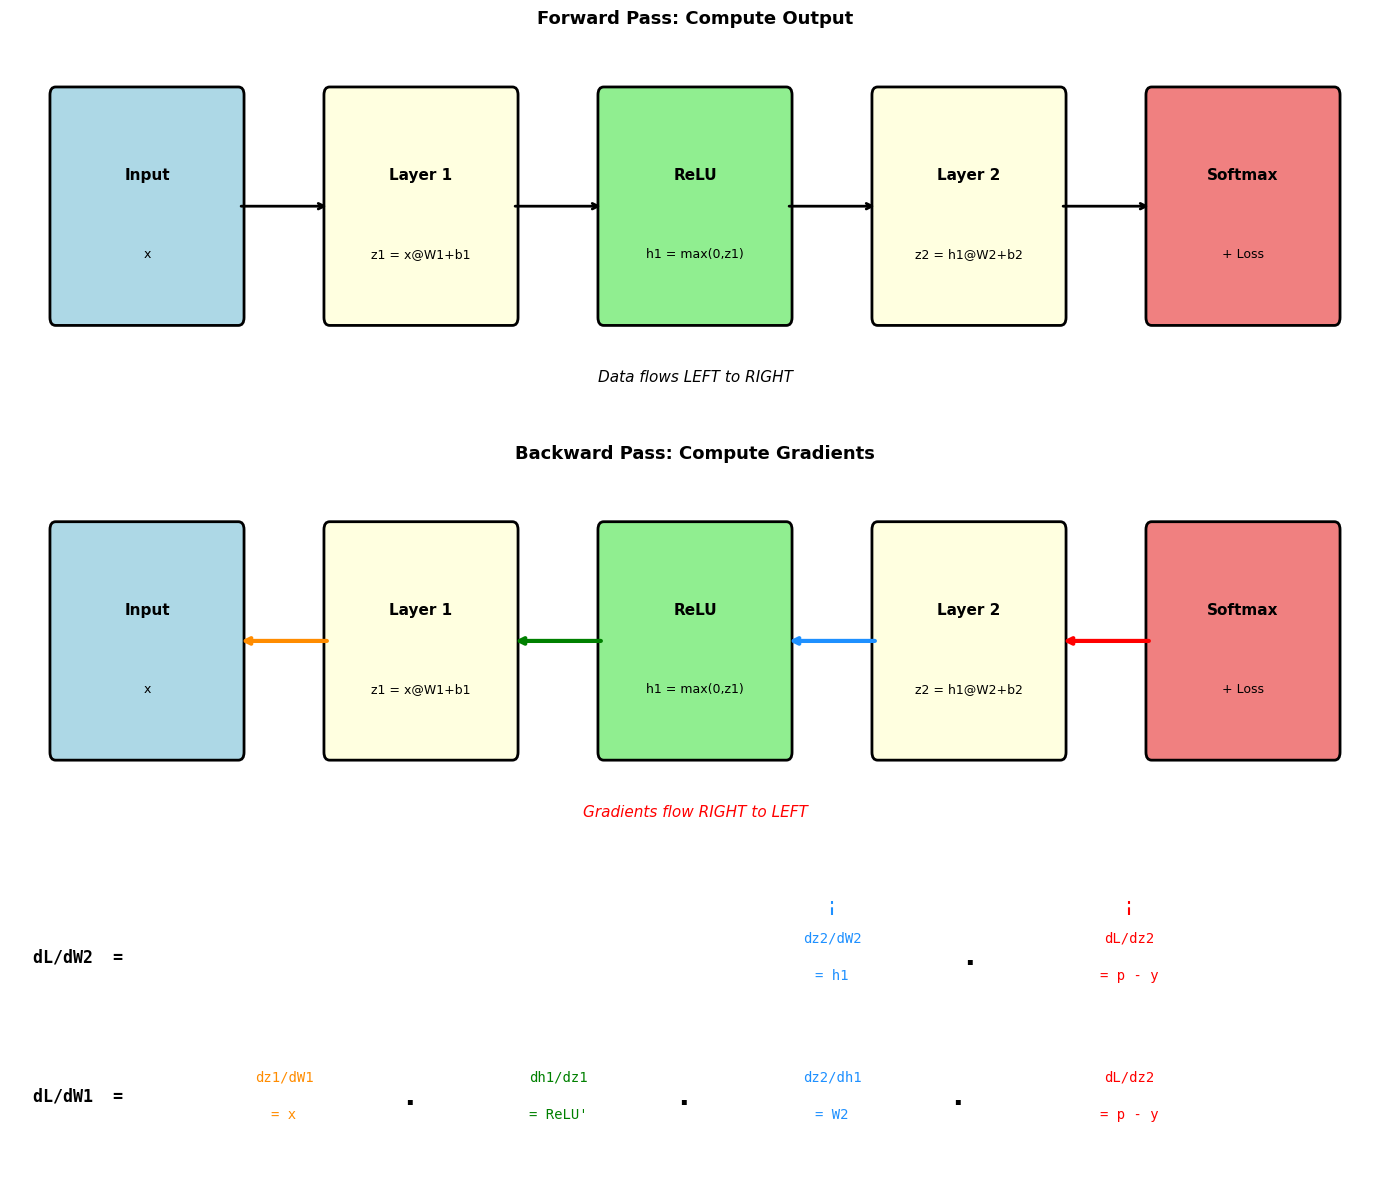

In [11]:
# Show forward and backward pass with chain rule formulas
fig, axes = plt.subplots(3, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 1, 0.7]})

# Forward pass
ax1 = axes[0]
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 2.5)
ax1.axis('off')
ax1.set_title('Forward Pass: Compute Output', fontsize=13, fontweight='bold')

boxes_fwd = [
    (1.2, 'Input', 'x', 'lightblue'),
    (3.6, 'Layer 1', 'z1 = x@W1+b1', 'lightyellow'),
    (6, 'ReLU', 'h1 = max(0,z1)', 'lightgreen'),
    (8.4, 'Layer 2', 'z2 = h1@W2+b2', 'lightyellow'),
    (10.8, 'Softmax', '+ Loss', 'lightcoral'),
]

for x, title, formula, color in boxes_fwd:
    ax1.add_patch(mpatches.FancyBboxPatch((x-0.8, 0.7), 1.6, 1.4, boxstyle='round,pad=0.05', 
                                          facecolor=color, edgecolor='black', linewidth=2))
    ax1.text(x, 1.6, title, ha='center', va='center', fontsize=11, fontweight='bold')
    ax1.text(x, 1.1, formula, ha='center', va='center', fontsize=9)

for i in range(len(boxes_fwd)-1):
    ax1.annotate('', xy=(boxes_fwd[i+1][0]-0.8, 1.4), xytext=(boxes_fwd[i][0]+0.8, 1.4),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

ax1.text(6, 0.3, 'Data flows LEFT to RIGHT', ha='center', fontsize=11, style='italic')

# Backward pass
ax2 = axes[1]
ax2.set_xlim(0, 12)
ax2.set_ylim(0, 2.5)
ax2.axis('off')
ax2.set_title('Backward Pass: Compute Gradients', fontsize=13, fontweight='bold')

for x, title, formula, color in boxes_fwd:
    ax2.add_patch(mpatches.FancyBboxPatch((x-0.8, 0.7), 1.6, 1.4, boxstyle='round,pad=0.05', 
                                          facecolor=color, edgecolor='black', linewidth=2))
    ax2.text(x, 1.6, title, ha='center', va='center', fontsize=11, fontweight='bold')
    ax2.text(x, 1.1, formula, ha='center', va='center', fontsize=9)

# Colored arrows for backward pass
arrow_colors = ['darkorange', 'green', 'dodgerblue', 'red']
for i in range(len(boxes_fwd)-1):
    ax2.annotate('', xy=(boxes_fwd[i][0]+0.8, 1.4), xytext=(boxes_fwd[i+1][0]-0.8, 1.4),
                arrowprops=dict(arrowstyle='->', color=arrow_colors[i], lw=3))

ax2.text(6, 0.3, 'Gradients flow RIGHT to LEFT', ha='center', fontsize=11, style='italic', color='red')

# Chain rule formulas at bottom
ax3 = axes[2]
ax3.set_xlim(0, 12)
ax3.set_ylim(0, 3)
ax3.axis('off')

# dL/dW2 (shorter chain - only 2 terms)
ax3.text(0.2, 2.4, 'dL/dW2  =', fontsize=12, fontweight='bold', va='center', family='monospace')
terms_w2 = [
    (7.2, 'dz2/dW2', '= h1', 'dodgerblue'),
    (9.8, 'dL/dz2', '= p - y', 'red'),
]
for i, (x, grad, value, color) in enumerate(terms_w2):
    ax3.text(x, 2.6, grad, fontsize=10, color=color, ha='center', va='center', family='monospace')
    ax3.text(x, 2.2, value, fontsize=10, color=color, ha='center', va='center', family='monospace')
    ax3.plot([x, x], [2.85, 3.0], '--', color=color, lw=1.5)
    if i < len(terms_w2) - 1:
        ax3.text(x + 1.2, 2.4, '.', fontsize=20, ha='center', va='center', fontweight='bold')

# dL/dW1 (full chain - all 4 terms)
ax3.text(0.2, 0.9, 'dL/dW1  =', fontsize=12, fontweight='bold', va='center', family='monospace')
terms_w1 = [
    (2.4, 'dz1/dW1', '= x', 'darkorange'),
    (4.8, 'dh1/dz1', "= ReLU'", 'green'),
    (7.2, 'dz2/dh1', '= W2', 'dodgerblue'),
    (9.8, 'dL/dz2', '= p - y', 'red'),
]
for i, (x, grad, value, color) in enumerate(terms_w1):
    ax3.text(x, 1.1, grad, fontsize=10, color=color, ha='center', va='center', family='monospace')
    ax3.text(x, 0.7, value, fontsize=10, ha='center', va='center', family='monospace', color=color)
    if i < len(terms_w1) - 1:
        ax3.text(x + 1.1, 0.9, '.', fontsize=20, ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


### The Key Gradients

For our two-layer edge detector (25 → 8 → 2):

**At the output (softmax + cross-entropy combined):**
$$\frac{\partial L}{\partial \mathbf{z}_2} = \mathbf{p} - \mathbf{y}$$

This is a vector (length 2). If true label is "Edge" ($\mathbf{y}=[1,0]$) and prediction is $\mathbf{p}=[0.9, 0.1]$:
- Gradient for Edge score: $0.9 - 1 = -0.1$ (negative → increase this score)
- Gradient for No-Edge score: $0.1 - 0 = +0.1$ (positive → decrease this score)

**Through ReLU:**
$$\frac{\partial h}{\partial z} = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$$

Applied element-wise to vectors. ReLU passes gradients through (for active neurons) or blocks them (for inactive neurons).

**For weight matrices:**
$$\frac{\partial L}{\partial W} = \mathbf{x}^T \cdot \frac{\partial L}{\partial \mathbf{z}}$$

Where $\mathbf{x}$ is the input vector to that layer, $\frac{\partial L}{\partial \mathbf{z}}$ is the gradient vector from above. The result is a matrix the same shape as $W$.

### How Gradients Update Weights

Once we have $\frac{\partial L}{\partial W}$ (a matrix of gradients), we update every weight at once:

$$W_{new} = W_{old} - \alpha \cdot \frac{\partial L}{\partial W}$$

**Concrete example for one weight:** Say $w = 0.5$, gradient $\frac{\partial L}{\partial w} = -0.2$, learning rate $\alpha = 0.1$:

$$w_{new} = 0.5 - 0.1 \times (-0.2) = 0.532$$

The gradient was negative (increasing this weight decreases loss), so we increased it!


**Implementation:** (backward pass — all matrix/vector operations)

```python
# Shapes for our network: x(1,25), W1(25,8), h1(1,8), W2(8,2), p(1,2)
dL_dz2 = p - y              # (1,2) output gradient
dL_dW2 = h1.T @ dL_dz2      # (8,1) @ (1,2) = (8,2) weight gradient
dL_dh1 = dL_dz2 @ W2.T      # (1,2) @ (2,8) = (1,8) backprop to hidden
dL_dz1 = dL_dh1 * (z1 > 0)  # (1,8) element-wise, ReLU gradient
dL_dW1 = x.T @ dL_dz1       # (25,1) @ (1,8) = (25,8) weight gradient
```

---

## Part 7: Watching It Learn

Let's put it all together! We'll train a tiny network on an edge detection task and watch the loss decrease.


**The Training Loop Structure:**

```python
for epoch in range(num_epochs):
    for x, y in training_data:
        
        # Forward pass (through both layers)
        z1 = x @ W1 + b1              # hidden layer
        h1 = relu(z1)                 # ReLU activation
        z2 = h1 @ W2 + b2             # output layer
        p = softmax(z2)               # probabilities
        loss = -np.sum(y * np.log(p)) # cross-entropy
        
        # Backward pass (chain rule, layer by layer)
        dL_dz2 = p - y                # output gradient
        dL_dW2 = h1.T @ dL_dz2        # output weights
        dL_dh1 = dL_dz2 @ W2.T        # backprop to hidden
        dL_dz1 = dL_dh1 * (z1 > 0)    # through ReLU
        dL_dW1 = x.T @ dL_dz1         # hidden weights
        
        # Update all weights
        W1 -= lr * dL_dW1
        W2 -= lr * dL_dW2
```

Each piece we've learned slots into this loop. Let's see it in action:

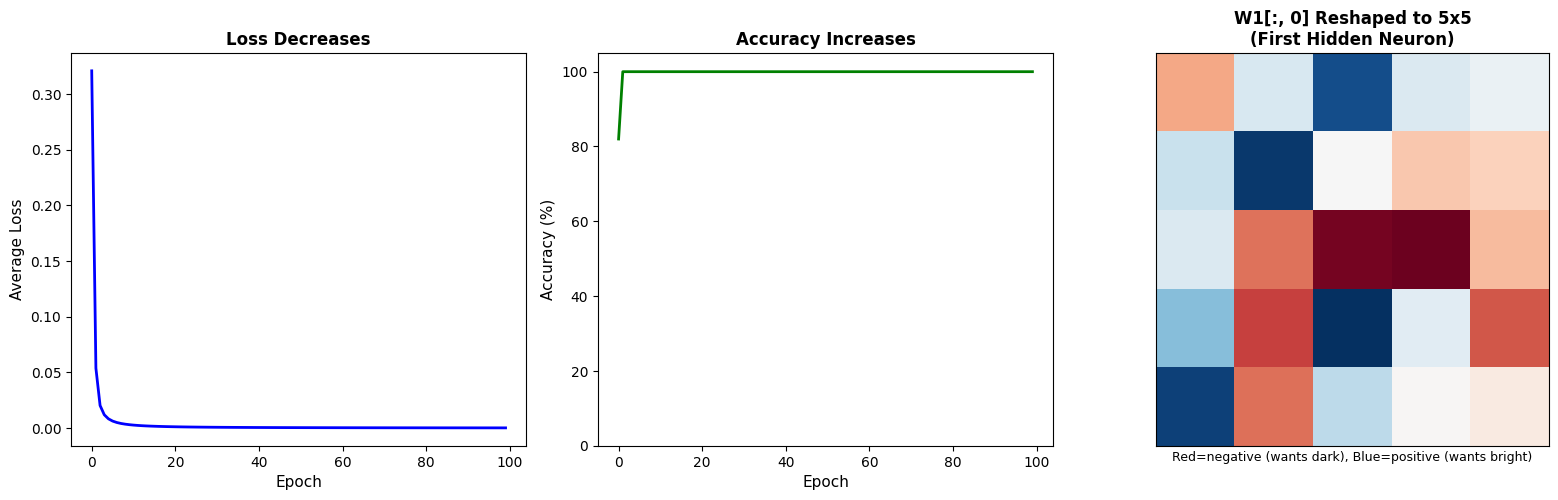

Final accuracy: 100.0%

Network architecture: 25 -> 8 (ReLU) -> 2 (softmax)
Total parameters: W1(25x8) + b1(8) + W2(8x2) + b2(2) = 226


In [12]:
# Train a 2-layer edge detector
np.random.seed(42)

# Create training data: 5x5 patches
def make_edge_patch():
    edge_col = np.random.randint(1, 4)
    patch = np.ones((5, 5)) * 0.1
    patch[:, edge_col:] = 0.9
    return patch.flatten(), np.array([1, 0])  # Edge

def make_no_edge_patch():
    if np.random.rand() > 0.5:
        patch = np.ones((5, 5)) * np.random.uniform(0.3, 0.7)
    else:
        patch = np.ones((5, 5)) * 0.9
        patch[:, 2:] = 0.1  # inverted
    return patch.flatten(), np.array([0, 1])  # No Edge

# Generate dataset
X_train, y_train = [], []
for _ in range(50):
    if np.random.rand() > 0.5:
        x, y = make_edge_patch()
    else:
        x, y = make_no_edge_patch()
    X_train.append(x)
    y_train.append(y)
X_train, y_train = np.array(X_train), np.array(y_train)

# Initialize 2-layer network: 25 -> 8 -> 2
hidden_size = 8
W1 = np.random.randn(25, hidden_size) * 0.3
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, 2) * 0.3
b2 = np.zeros((1, 2))

# Training
learning_rate = 0.1
losses, accuracies = [], []

for epoch in range(100):
    epoch_loss, correct = 0, 0
    
    for i in range(len(X_train)):
        x = X_train[i:i+1]
        y = y_train[i:i+1]
        
        # Forward pass
        z1 = x @ W1 + b1              # (1,25) @ (25,8) = (1,8)
        h1 = np.maximum(0, z1)        # ReLU
        z2 = h1 @ W2 + b2             # (1,8) @ (8,2) = (1,2)
        exp_z = np.exp(z2 - np.max(z2))
        p = exp_z / np.sum(exp_z)     # softmax
        
        # Loss & accuracy
        loss = -np.sum(y * np.log(p + 1e-8))
        epoch_loss += loss
        if np.argmax(p) == np.argmax(y):
            correct += 1
        
        # Backward pass
        dL_dz2 = p - y
        dL_dW2 = h1.T @ dL_dz2
        dL_db2 = dL_dz2
        dL_dh1 = dL_dz2 @ W2.T
        dL_dz1 = dL_dh1 * (z1 > 0)    # ReLU gradient
        dL_dW1 = x.T @ dL_dz1
        dL_db1 = dL_dz1
        
        # Update all weights
        W1 -= learning_rate * dL_dW1
        b1 -= learning_rate * dL_db1
        W2 -= learning_rate * dL_dW2
        b2 -= learning_rate * dL_db2
    
    losses.append(epoch_loss / len(X_train))
    accuracies.append(correct / len(X_train) * 100)

# Plot results
fig = plt.figure(figsize=(16, 5))

# Loss curve
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(losses, 'b-', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Average Loss', fontsize=11)
ax1.set_title('Loss Decreases', fontsize=12, fontweight='bold')

# Accuracy curve
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(accuracies, 'g-', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.set_title('Accuracy Increases', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 105)

# Learned W1 weights - show first hidden neuron
ax3 = fig.add_subplot(1, 3, 3)
w1_neuron0 = W1[:, 0].reshape(5, 5)  # First hidden neuron's weights
im = ax3.imshow(w1_neuron0, cmap='RdBu', vmin=-np.max(np.abs(w1_neuron0)), vmax=np.max(np.abs(w1_neuron0)))
ax3.set_title('W1[:, 0] Reshaped to 5x5\n(First Hidden Neuron)', fontsize=12, fontweight='bold')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('Red=negative (wants dark), Blue=positive (wants bright)', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Final accuracy: {accuracies[-1]:.1f}%")
print(f"\nNetwork architecture: 25 -> {hidden_size} (ReLU) -> 2 (softmax)")
print(f"Total parameters: W1({25}x{hidden_size}) + b1({hidden_size}) + W2({hidden_size}x2) + b2(2) = {25*hidden_size + hidden_size + hidden_size*2 + 2}")


### What Happened?

1. **Loss decreased** — the network got better at predicting
2. **Accuracy increased** — from ~50% (random guessing) to nearly 100%
3. **W1 learned edge patterns** — the first hidden neuron's weights (W1[:, 0] reshaped to 5×5) show the classic edge detector: negative on left, positive on right!

The network discovered the edge detection pattern **automatically** through gradient descent. We never told it what an edge looks like — it figured it out from examples.

Each of the 8 hidden neurons learns a different pattern. The output layer (W2) then combines these patterns to make the final Edge/No-Edge decision.


---

## Try It Yourself: Complete Edge Detector in ~80 Lines

Here's a self-contained example with everything we've learned: a **two-layer network** with ReLU activation. It includes data generation, forward pass, backward pass (with backpropagation through both layers), and training.

Architecture: **25 inputs → 8 hidden neurons (ReLU) → 2 outputs (softmax)**


In [13]:
"""
Complete Neural Network Edge Detector
=====================================
A minimal, self-contained example using only NumPy.
Now with a hidden layer and ReLU!
"""

import numpy as np

# ============================================================
# 1. CREATE TRAINING DATA
# ============================================================
np.random.seed(42)

def make_data(n_samples=100):
    """Generate edge and non-edge image patches."""
    X, y = [], []
    for _ in range(n_samples):
        if np.random.rand() > 0.5:
            # Edge: dark on left, bright on right
            edge_pos = np.random.randint(1, 4)
            patch = np.ones((5, 5)) * 0.1
            patch[:, edge_pos:] = 0.9
            label = [1, 0]  # Edge
        else:
            # No edge: uniform or inverted
            if np.random.rand() > 0.5:
                patch = np.ones((5, 5)) * np.random.uniform(0.3, 0.7)
            else:
                patch = np.ones((5, 5)) * 0.9
                patch[:, 2:] = 0.1  # bright-to-dark (not an edge)
            label = [0, 1]  # No Edge
        X.append(patch.flatten())
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = make_data(100)
X_test, y_test = make_data(20)

# ============================================================
# 2. INITIALIZE NETWORK
# ============================================================
# Two-layer network: 25 inputs -> 8 hidden (ReLU) -> 2 outputs
hidden_size = 8

W1 = np.random.randn(25, hidden_size) * 0.3
b1 = np.zeros((1, hidden_size))

W2 = np.random.randn(hidden_size, 2) * 0.3
b2 = np.zeros((1, 2))

learning_rate = 0.1

# ============================================================
# 3. DEFINE FORWARD AND BACKWARD PASS
# ============================================================
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

def forward(x):
    """Forward pass through both layers."""
    z1 = x @ W1 + b1           # hidden layer weighted sum
    h1 = relu(z1)              # ReLU activation
    z2 = h1 @ W2 + b2          # output layer weighted sum
    p = softmax(z2)            # softmax probabilities
    return z1, h1, z2, p

def compute_loss(p, y):
    return -np.sum(y * np.log(p + 1e-8))

def backward(x, z1, h1, p, y):
    """Backward pass using the chain rule."""
    # Output layer gradients
    dL_dz2 = p - y                    # softmax + cross-entropy gradient
    dL_dW2 = h1.T @ dL_dz2            # weight gradient = input.T @ gradient
    dL_db2 = dL_dz2
    
    # Backpropagate through hidden layer
    dL_dh1 = dL_dz2 @ W2.T            # gradient flows back through W2
    dL_dz1 = dL_dh1 * relu_derivative(z1)  # gradient through ReLU
    dL_dW1 = x.T @ dL_dz1             # weight gradient = input.T @ gradient
    dL_db1 = dL_dz1
    
    return dL_dW1, dL_db1, dL_dW2, dL_db2

# ============================================================
# 4. TRAINING LOOP
# ============================================================
print("Training 2-layer network: 25 -> 8 (ReLU) -> 2")
for epoch in range(100):
    total_loss = 0
    for i in range(len(X_train)):
        x = X_train[i:i+1]
        y = y_train[i:i+1]
        
        # Forward
        z1, h1, z2, p = forward(x)
        loss = compute_loss(p, y)
        total_loss += loss
        
        # Backward
        dL_dW1, dL_db1, dL_dW2, dL_db2 = backward(x, z1, h1, p, y)
        
        # Update all weights
        W1 -= learning_rate * dL_dW1
        b1 -= learning_rate * dL_db1
        W2 -= learning_rate * dL_dW2
        b2 -= learning_rate * dL_db2
    
    if epoch % 20 == 0:
        print(f"  Epoch {epoch:2d}: Loss = {total_loss/len(X_train):.4f}")

# ============================================================
# 5. EVALUATE ON TEST SET
# ============================================================
correct = 0
for i in range(len(X_test)):
    _, _, _, p = forward(X_test[i:i+1])
    if np.argmax(p) == np.argmax(y_test[i]):
        correct += 1

print(f"\nTest Accuracy: {correct}/{len(X_test)} = {100*correct/len(X_test):.1f}%")

# ============================================================
# 6. EXAMINE WHAT THE NETWORK LEARNED
# ============================================================
print(f"\nHidden layer: {hidden_size} neurons, each looking for a different pattern")
print(f"Output layer: combines hidden features to classify Edge vs No-Edge")
print(f"\nTotal parameters: {25*hidden_size + hidden_size + hidden_size*2 + 2} = {25*hidden_size + hidden_size + hidden_size*2 + 2}")


Training 2-layer network: 25 -> 8 (ReLU) -> 2
  Epoch  0: Loss = 0.1423
  Epoch 20: Loss = 0.0005
  Epoch 40: Loss = 0.0002


  Epoch 60: Loss = 0.0001


  Epoch 80: Loss = 0.0001

Test Accuracy: 20/20 = 100.0%

Hidden layer: 8 neurons, each looking for a different pattern
Output layer: combines hidden features to classify Edge vs No-Edge

Total parameters: 226 = 226


---

## Summary

We've built up a complete picture of how neural networks learn:

**The Forward Pass:**
1. **Neurons** compute weighted sums + ReLU activation (Part 2)
2. **Softmax** converts scores to probabilities (Part 3)
3. **Loss** measures how wrong we are (Part 4)

**The Backward Pass:**
4. **Chain rule** lets us compute derivatives through composed functions (Interlude)
5. **Gradient descent** updates weights opposite to the gradient (Part 5)
6. **Backpropagation** efficiently computes all gradients layer by layer (Part 6)

**Key Formulas:**
- Neuron: $h = \max(0, \sum_i x_i w_i + b)$
- Softmax: $P_j = \frac{e^{z_j}}{\sum_k e^{z_k}}$
- Loss: $L = -\log(p_{correct})$
- Update: $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$

**The Magic:** By repeating forward-pass, loss, backward-pass, update thousands of times, the network discovers the right weights automatically!

---

**Next Up:** [Building a Flexible Neural Network](nn_flexible_network_blog.html) — Generalize the code from this tutorial to handle any number of layers, with a clean `Layer` class abstraction. Same principles, but now you can build networks of any depth!

---

**Further Reading:**
- [How Neural Networks Learn to See](nn_edge_detector_blog.html) — Deep dive into how a single neuron detects patterns (weights, ReLU, bias)
- [3Blue1Brown Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) — Excellent video explanations
